<a href="https://colab.research.google.com/github/cathyxinchangli/ATMS-597-SP-2020/blob/master/ATMS-597-SP-2020-Project-2/examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
import numpy as np
import pandas as pd
import datetime

import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

%matplotlib inline

# assumptions:
# 1. Reference period: 1970.1.1 - 1998.12.31 due to data availability
# 2. Anomaly: raw, not standardized
# 3. Leap year: (TBD Yang?)
# 4. Treatment for extra days outside of 52 weeks
# 5. ...

# Functions

## Get Data

In [0]:
def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    ---
    S. Moline, 'Hands on Data Analysis with Pandas'
    https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_04/0-weather_data_collection.ipynb
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'HfZphTTGbXckpmEuqevAXQZFRCTEJgkJ' # obtained by X. Li, 2/4/2020
        },
        params=payload
    )

def fetch_data(locationid, startdate, enddate, endpoint="data",
               datasetid="GHCND", stationid=None, units="metric", limit=1000):
    """
    Simple fetch request for requesting TMIN and TMAX data from API within 
    the same year.

    Parameters:
        - datasetid: default 'GHCND',
        - locationid
        - stationid 
        - startdate: a datetime object
        - enddate: a datetime object
        - units: specify preferred units for retrieving the data
        - limit: max. 1000 requests

    Returns:
        - DataFrame of the requested dataset

    """
    response = make_request(
        endpoint,
        {
            "datasetid": datasetid,
            "datatypeid": ["TMAX", "TMIN"],
            "locationid": locationid,
            "stationid": stationid,
            "startdate": startdate,
            "enddate": enddate,
            "unit": units,
            "limit": limit,
        })
    response = pd.DataFrame(response.json()["results"])
    return response

def loop_request(locationid, startdate, enddate, endpoint="data",
                 datasetid="GHCND", stationid=None, units="metric", limit=1000):
    """
    Fetch TMIN and TMAX data from API over arbitrary time period without 
    running into data request limit.

    Parameters:
        - datasetid: default 'GHCND',
        - locationid
        - stationid: default None
        - startdate: a datetime object
        - enddate: a datetime object
        - units: preferred units for retrieving the data, default 'metric'
        - limit: max. 1000 requests

    Returns:
        - DataFrame of the requested dataset

    """
    if startdate.year == enddate.year:
        return fetch_data(locationid, startdate, enddate, endpoint, datasetid, 
                          stationid, units, limit)
    else:
        enddate_0 = datetime.date(startdate.year, 12, 31)
        df_tmp_0 = fetch_data(locationid, startdate, enddate_0, endpoint, datasetid, 
                            stationid, units, limit)
        for year in range(startdate.year + 1, enddate.year):
            startdate_tmp = datetime.date(year, 1, 1)
            enddate_tmp = datetime.date(year + 1, 1, 1)
            df_tmp = fetch_data(locationid, startdate_tmp, enddate_tmp, endpoint, datasetid, 
                                stationid, units, limit)
            df_tmp_0 = pd.concat([df_tmp_0, df_tmp])
        startdate_1 = datetime.date(enddate.year, 1, 1)
        df_tmp_1 = fetch_data(locationid, startdate_1, enddate, endpoint, datasetid, 
                                stationid, units, limit)
        df_tmp_0 = pd.concat([df_tmp_0, df_tmp_1])
        return df_tmp_0
        
def clean_up(datain):
    '''
    Clean up missing values, adjust the units of the values, covert datetime 
    format to pandas-datetime and re-index using datetime.

    Parameters:
        - datain: the DataFrame to perform the function on
    
    Returns:
        cleaned up DataFrame
    ---
    Adapted from S. Nesbitt, Module 2, ATMS 597 SP 2020
    '''
    # clean up missing values
    datain["value"][(np.abs(datain["value"])==9999)] = np.nan
    datain.dropna(inplace=True)
    # adjust unit from 10th of degree C to degree C
    datain["value"] = datain["value"].astype("float") / 10.
    # convert datetime format and re-index
    datain["date"] = pd.to_datetime(datain["date"], infer_datetime_format=True) # this is hard coded
    datain.index = datain["date"]
    return datain

## Calculate Anomalies

In [0]:
def is_leap_and_last_day(s):
    """
    TBD by Yang
    """
    return ((s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 12) & (s.index.day == 30)) | ((s.index.month == 12) & (s.index.day == 31))

def cal_anomaly_W(df, df_ref):
    """
    TBD
    """
    # Calculate reference weekly temperature from 1970 to the end of 1998
    mask = is_leap_and_last_day(df_ref)
    df_ref_tmp = df_ref[~mask]
    df_ref_tmp["W_num"] = (df_ref_tmp["date"].dt.dayofyear - 1) // 7
    df_ref_W = df_ref_tmp.groupby("W_num").mean()
    
    mask = is_leap_and_last_day(df)
    df_tmp = df[~mask]
    df_W = df_tmp.resample("7D").mean()
    df_W["W_num"] = (df_W.index.dayofyear - 1) // 7
    
    for num in set(df_W["W_num"]):
        df_W["value"][df_W["W_num"]==num] -= df_ref_W["value"][num]
        
    return df_W, df_ref_W

def cal_anomaly_M(df, df_ref):
    """
    TBD
    """
    # reference frame:
    df_ref_tmp = df_ref.resample('MS').mean()
    df_ref_tmp['M_num'] = df_ref_tmp.index.month
    df_ref_M = df_ref_tmp.groupby('M_num').mean()

    # plotting frame:
    df_M = df.resample('MS').mean() # this will fill incomplete months into complete ones and place the mean into the first day of the month
    df_M['M_num'] = df_M.index.month

    # calculate anomaly:
    for num in set(df_M['M_num']):
        df_M['value'][df_M['M_num']==num] -= df_ref_M['value'][num]
    
    return df_M, df_ref_M

def cal_anomaly_Y(df, df_ref):
    """
    TBD
    """
    # reference frame (just a number now)
    df_ref_Y = df_ref['value'].mean()

    # plotting frame:
    df_Y = df.resample('AS').mean() # this will fill incomplete years into complete ones and place the mean into the first day of the year

    # calculate anomaly:
    df_Y['value'] -= df_ref_Y
    
    return df_Y, df_ref_Y

## Plot

In [0]:
def stripe_plot(df_in, df_ref, freq, flag=True):
    '''
    the plotting function for warming stripes.
    
    Inputs:
        - df: the conditioned DataFrame for plotting;
        - df_ref: the reference DataFrame for calculating the anomaly
        - freq: 'W', 'M', or 'Y'
            frequency for calculating and ploting the anomaly
        - flag: Boolean
            whether to plot the data points over the strips or not. Default is True.
    
    Returns:
        warming stripes figure named 'warming-stripe-[freq].png'.
    ---
    Maximilian Nöthe, 'Creating the Warming Stripes in Matplotlib'
    https://matplotlib.org/matplotblog/posts/warming-stripes/
    '''
    if freq == 'W':
        df = cal_anomaly_W(df_in, df_ref)[0] # call in the func that calculates weekly anomaly
        interval = 7
    elif freq == 'M':
        df = cal_anomaly_M(df_in, df_ref)[0]
        interval = 31
    elif freq == 'Y':
        df = cal_anomaly_Y(df_in, df_ref)[0]
        interval = 366
    else:
        print('Please enter a valid frequency (W, M, or Y)')
    
    max_temp = df["value"].max()
    min_temp = df["value"].min()
    temp_delta = max_temp - min_temp # deg C
    buffer = 0.2 # deg C
    
    cmap = ListedColormap([
        '#08306b', '#08519c', '#2171b5', '#4292c6',
        '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
        '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
        '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
    ])

    stripes = len(df.index)
    fig = plt.figure(figsize=(min(0.2*stripes,12), 5))
    ax = fig.add_axes([0.1, 0.12, 0.9, 0.88])
    
    date_str_list = ['{}'.format(d) for d in df.index]
    date_corrected = mdates.datestr2num(date_str_list)

    col = PatchCollection([
        Rectangle( (y, min_temp-buffer), interval, temp_delta+2*buffer) 
        for y in date_corrected.astype(int)
    ]) 
    # set data, colormap and color limits
    col.set_array(df['value'])
    col.set_cmap(cmap)
    col.set_clim(min_temp, max_temp)
    ax.add_collection(col)
    ax.set_ylim(min_temp-buffer, max_temp+buffer)
    ax.set_xlim(date_corrected[0], date_corrected[-1])
    formatter = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()
    ax.set_xlabel('date')
    # flag
    if flag == True:
        ax.plot(df['value'],':o',color='gold',linewidth=3, markersize=10)
        ax.set_ylabel('temperature [deg C]')
    else:
        ax.axes.get_yaxis().set_visible(False)
    fig.savefig('warming-stripes-'+freq+'.png')
    fig.show()

# Example
Location: NYC<br>
Start Date: 12/1/2015<br>
End Date: 2/1/2018

### Get reference dataset

In [5]:
df_ref = loop_request(locationid="CITY:SP000001", startdate=datetime.date(1970, 1, 1), enddate=datetime.date(1998, 12, 31), stationid="GHCND:SPE00155259")
df_ref = clean_up(df_ref)

''' Uncomment to display output '''
# display(df_ref.describe(), df_ref.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


' Uncomment to display output '

### Get the dataset

In [11]:
df = loop_request(locationid="CITY:SP000001", startdate=datetime.date(1990, 1, 1), enddate=datetime.date(2013, 12, 31), stationid="GHCND:SPE00155259")
df = clean_up(df)

''' Uncomment to display output '''
# display(df.describe(), df.head(), df.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


' Uncomment to display output '

### Weekly

<b>Calculate Anomalies</b>

In [12]:
df_W, df_ref_W = cal_anomaly_W(df, df_ref)

''' Uncomment to display output '''
# display(df_ref_W, df.head(), df_W.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: ignored

<b>Plot Climate Stripes</b>

In [13]:
stripe_plot(df, df_ref, freq='W', flag=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: ignored

### Monthly

<b>Calculate Anomalies</b>

In [14]:
df_M, df_ref_M = cal_anomaly_M(df, df_ref)

''' Uncomment to display output '''
# display(df_ref_M, df.head(), df_M.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


' Uncomment to display output '

<b>Plot Climate Stripes</b>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


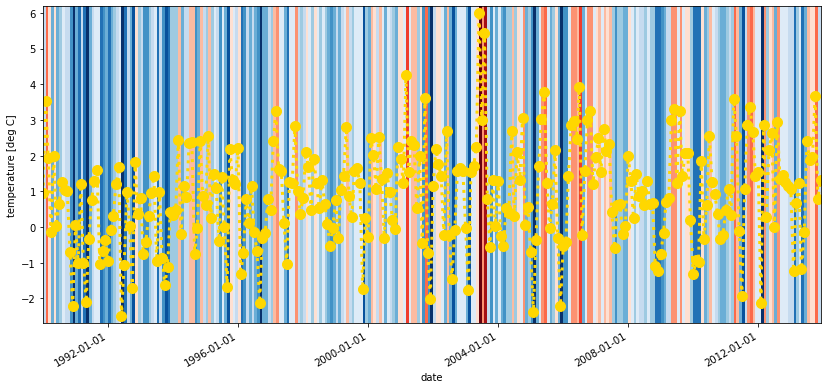

In [15]:
stripe_plot(df, df_ref, freq='M', flag=1)

### Yearly

<b> Calculate Anomalies </b>

In [17]:
df_Y, df_ref_Y = cal_anomaly_Y(df, df_ref)

''' Uncomment to display output '''
# display(df_ref_Y, df.head(), df_Y.head())

' Uncomment to display output '

<b> Plot Climate Stripes

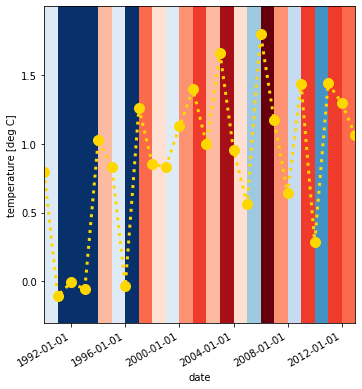

In [18]:
stripe_plot(df, df_ref, freq='Y', flag=1)